## Beispiel Referenzpunkt

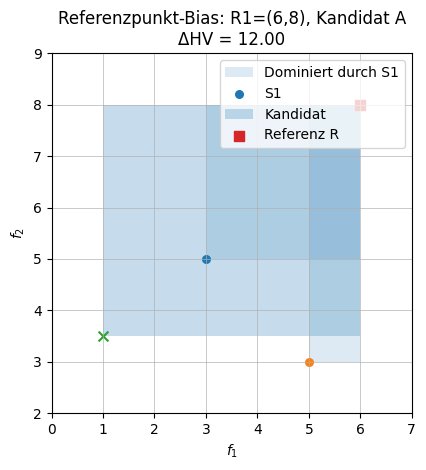

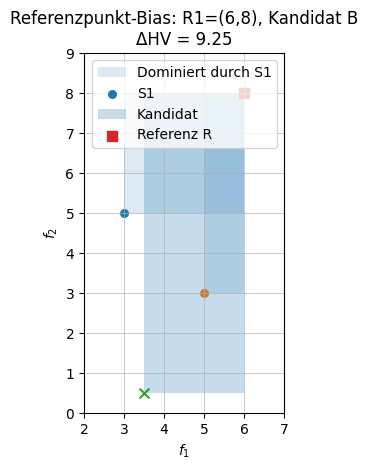

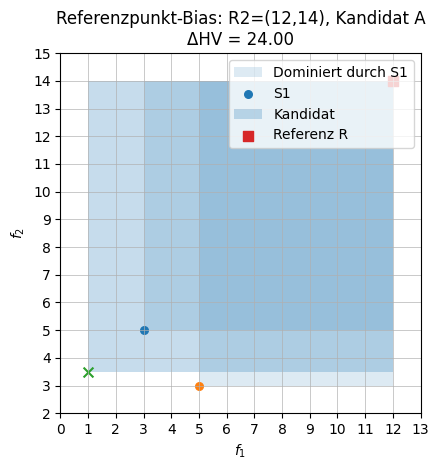

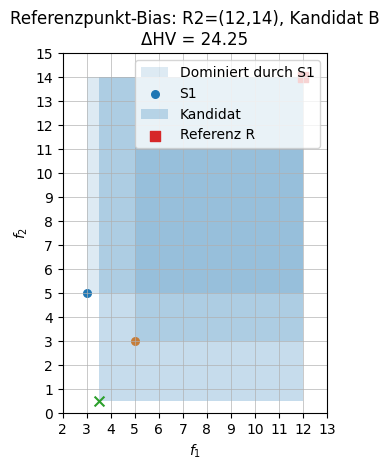

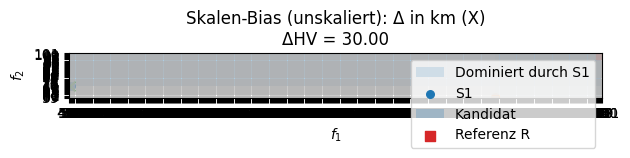

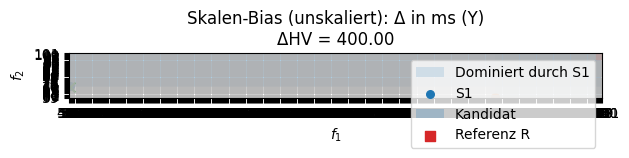

In [36]:
# Jupyter-ready demo: plots are DISPLAYED (plt.show) instead of saved.
# - Reference-point bias with TWO archive points
# - Scaling bias with TWO archive points
# Grid is set to 1-unit steps by default; change grid_step_* if desired.

import math
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import MultipleLocator

# ---------- Geometry / HV utilities ----------

def rect_from_point(p, R):
    """
    Axis-aligned rectangle for 2D minimization: from point p to reference R.
    Returns (x, y, w, h) or None if degenerate.
    """
    x, y = p
    rx, ry = R
    w, h = rx - x, ry - y
    if w <= 0 or h <= 0:
        return None
    return (x, y, w, h)

def rects_union_area(rects):
    """
    Union area of a small set of axis-aligned rectangles.
    Each rect is (x, y, w, h). Robust scanline over x.
    """
    xs = set()
    clean = []
    for r in rects:
        if r is None: 
            continue
        x, y, w, h = r
        if w <= 0 or h <= 0:
            continue
        x1, x2 = x, x + w
        y1, y2 = y, y + h
        xs.add(x1); xs.add(x2)
        clean.append((x1, x2, y1, y2))
    if not clean:
        return 0.0
    xs = sorted(xs)
    area = 0.0
    for i in range(len(xs)-1):
        xa, xb = xs[i], xs[i+1]
        if xb <= xa:
            continue
        intervals = [(y1, y2) for x1, x2, y1, y2 in clean if x1 < xb and x2 > xa]
        if not intervals:
            continue
        intervals.sort()
        merged = []
        cy1, cy2 = intervals[0]
        for yy1, yy2 in intervals[1:]:
            if yy1 <= cy2:
                cy2 = max(cy2, yy2)
            else:
                merged.append((cy1, cy2))
                cy1, cy2 = yy1, yy2
        merged.append((cy1, cy2))
        ylen = sum(y2 - y1 for y1, y2 in merged)
        area += (xb - xa) * ylen
    return float(area)

def delta_hv(S_points, cand, R):
    """
    Hypervolume contribution ΔHV of candidate 'cand', given archive S_points and reference R.
    """
    rects_S = [rect_from_point(s, R) for s in S_points]
    rect_c = rect_from_point(cand, R)
    A_before = rects_union_area(rects_S)
    A_after  = rects_union_area(rects_S + [rect_c])
    return A_after - A_before

# ---------- Plot helper (with grid in unit steps) ----------

def _nice_limits(values, pad=0.5):
    vmin = min(values)
    vmax = max(values)
    lo = math.floor(vmin - pad)
    hi = math.ceil (vmax + pad)
    if lo == hi:  # degenerate
        lo -= 1
        hi += 1
    return lo, hi

def plot_archiv_and_candidate(
    S_points, cand, R, title,
    grid_step_x=1.0, grid_step_y=1.0
):
    fig = plt.figure()
    ax = plt.gca()

    # Archive rectangles + points
    for i, s in enumerate(S_points, start=1):
        rs = rect_from_point(s, R)
        if rs:
            ax.add_patch(Rectangle((rs[0], rs[1]), rs[2], rs[3], alpha=0.15, linewidth=1,
                                   label=f"Dominiert durch S{i}" if i == 1 else None))
        ax.scatter([s[0]],[s[1]], s=30, label=f"S{i}" if i == 1 else None)

    # Candidate
    rc = rect_from_point(cand, R)
    if rc:
        ax.add_patch(Rectangle((rc[0], rc[1]), rc[2], rc[3], alpha=0.25, linewidth=1, label="Kandidat"))
    ax.scatter([cand[0]],[cand[1]], marker='x', s=50)

    # Reference point
    ax.scatter([R[0]],[R[1]], marker='s', s=50, label="Referenz R")

    # ΔHV in title
    dHV = delta_hv(S_points, cand, R)
    ax.set_title(f"{title}\nΔHV = {dHV:.2f}")
    ax.set_xlabel("$f_1$")
    ax.set_ylabel("$f_2$")

    # "Nice" integer limits
    all_x = [p[0] for p in S_points] + [cand[0], R[0]]
    all_y = [p[1] for p in S_points] + [cand[1], R[1]]
    xlo, xhi = _nice_limits(all_x, pad=0.5)
    ylo, yhi = _nice_limits(all_y, pad=0.5)
    ax.set_xlim(xlo, xhi)
    ax.set_ylim(ylo, yhi)
    ax.set_aspect('equal', adjustable='box')

    # Unit grid (adjustable)
    ax.xaxis.set_major_locator(MultipleLocator(grid_step_x))
    ax.yaxis.set_major_locator(MultipleLocator(grid_step_y))
    ax.grid(True, which='major', linewidth=0.6, alpha=0.8)

    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

# ---------- (1) Reference-point bias: two archive points ----------

def render_refbias_two_archives(grid_step_x=1.0, grid_step_y=1.0):
    S = [(3, 5), (5, 3)]
    A = (1, 3.5)
    B = (3.5, 0.5)
    R1 = (6, 8)       # near
    R2 = (12, 14)     # far

    plot_archiv_and_candidate(S, A, R1,
        "Referenzpunkt-Bias: R1=(6,8), Kandidat A",
        grid_step_x=grid_step_x, grid_step_y=grid_step_y)

    plot_archiv_and_candidate(S, B, R1,
        "Referenzpunkt-Bias: R1=(6,8), Kandidat B",
        grid_step_x=grid_step_x, grid_step_y=grid_step_y)

    plot_archiv_and_candidate(S, A, R2,
        "Referenzpunkt-Bias: R2=(12,14), Kandidat A",
        grid_step_x=grid_step_x, grid_step_y=grid_step_y)

    plot_archiv_and_candidate(S, B, R2,
        "Referenzpunkt-Bias: R2=(12,14), Kandidat B",
        grid_step_x=grid_step_x, grid_step_y=grid_step_y)

# ---------- (2) Scaling bias: two archive points (unscaled) ----------

def render_scalebias_two_archives(grid_step_x=1.0, grid_step_y=1.0):
    # f1 in km (0..1000), f2 in ms (0..100)
    S = [(500, 70), (900, 60)]
    X = (499, 70)   # -1 km
    Y = (500, 69)   # -1 ms
    R = (1000, 100)

    plot_archiv_and_candidate(S, X, R,
        "Skalen-Bias (unskaliert): Δ in km (X)",
        grid_step_x=grid_step_x, grid_step_y=grid_step_y)

    plot_archiv_and_candidate(S, Y, R,
        "Skalen-Bias (unskaliert): Δ in ms (Y)",
        grid_step_x=grid_step_x, grid_step_y=grid_step_y)

# ---------- Execute (display plots) ----------

# 1) Reference-point bias with unit grid
render_refbias_two_archives(grid_step_x=1.0, grid_step_y=1.0)

# 2) Scaling bias with unit grid
# Note: For km on x (0..1000), a 1-unit grid is very dense; increase to 10 if preferred.
render_scalebias_two_archives(grid_step_x=1.0, grid_step_y=1.0)


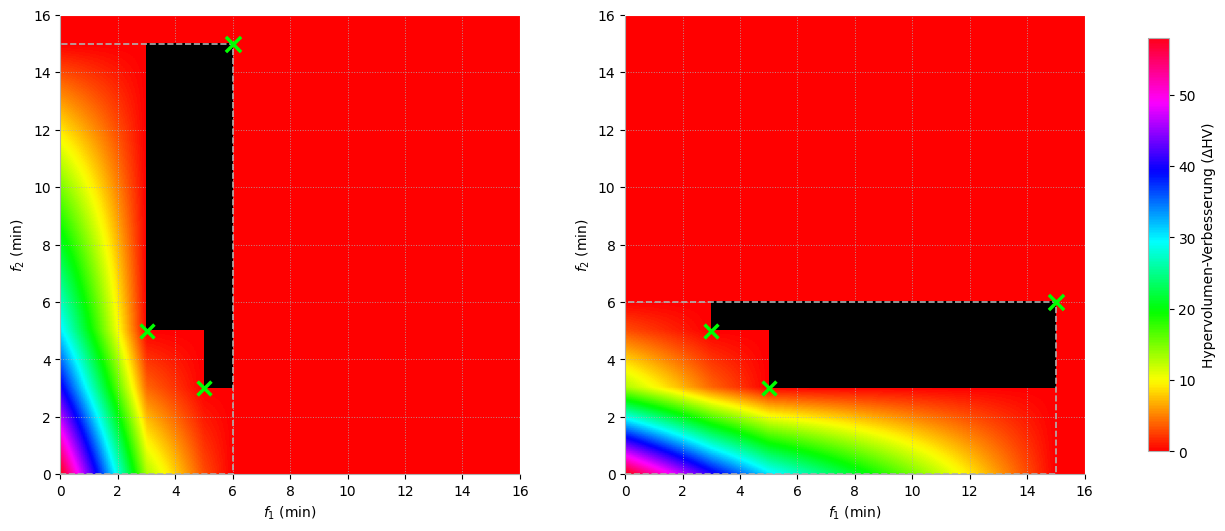

In [34]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import to_rgba

# ---------- Geometrie / HV (unverändert)----------
def rect_from_point(p, R):
    x, y = p
    rx, ry = R
    w, h = rx - x, ry - y
    if w <= 0 or h <= 0:
        return None
    return (x, y, w, h)

def union_area(rects):
    xs = set()
    clean = []
    for r in rects:
        if r is None:
            continue
        x, y, w, h = r
        if w <= 0 or h <= 0:
            continue
        clean.append((x, x+w, y, y+h))
        xs.add(x); xs.add(x+w)
    if not clean:
        return 0.0
    xs = sorted(xs)
    total = 0.0
    for i in range(len(xs)-1):
        xa, xb = xs[i], xs[i+1]
        if xb <= xa:
            continue
        intervals = []
        for x1, x2, y1, y2 in clean:
            if x1 < xb and x2 > xa:
                intervals.append((y1, y2))
        if not intervals:
            continue
        intervals.sort()
        merged = []
        cy1, cy2 = intervals[0]
        for y1, y2 in intervals[1:]:
            if y1 <= cy2:
                cy2 = max(cy2, y2)
            else:
                merged.append((cy1, cy2))
                cy1, cy2 = y1, y2
        merged.append((cy1, cy2))
        ylen = sum(b - a for a, b in merged)
        total += (xb - xa) * ylen
    return total

def delta_hv(S_points, cand, R):
    rects_S = [rect_from_point(s, R) for s in S_points]
    rc = rect_from_point(cand, R)
    return union_area(rects_S + [rc]) - union_area(rects_S)

def compute_heatmap(S_points, R, XMAX=16, YMAX=16, n=240):
    xs = np.linspace(0, XMAX, n)
    ys = np.linspace(0, YMAX, n)
    Z = np.zeros((n, n), dtype=float)
    for i, y in enumerate(ys):
        for j, x in enumerate(xs):
            z = delta_hv(S_points, (x, y), R)
            Z[i, j] = max(0.0, z)
    return xs, ys, Z

# ---------- Visuals (unverändert) ----------
def draw_hv_union_overlay(ax, S, R, color="tab:green", alpha=1.0, res=400, zorder=2):
    rx, ry = R
    xs = np.linspace(0, rx, res)
    ys = np.linspace(0, ry, res)
    X, Y = np.meshgrid(xs, ys)
    mask = np.zeros_like(X, dtype=bool)
    for sx, sy in S:
        mask |= (X >= sx) & (Y >= sy)
    rgba = list(to_rgba(color)); rgba[3] = alpha
    overlay = np.zeros((res, res, 4), dtype=float)
    overlay[mask] = rgba
    ax.imshow(overlay, origin="lower", extent=[0, rx, 0, ry], interpolation="nearest", zorder=zorder)

def draw_heatmap_on_ax(
    ax, S, xs, ys, Z, R, Zmax,
    heatmap_cmap="cividis",
    s_color="#222222", r_color="tab:red",
    hv_color="#2CA02C", hv_alpha=1.0,
    marker_size=90, cross_lw=2.2,
    show_title=False, title=None,
    bg_color='white', text_color='black', grid_color='lightgray'
):
    ax.set_facecolor(bg_color)
    im = ax.imshow(
        Z, origin='lower',
        extent=[xs[0], xs[-1], ys[0], ys[-1]],
        aspect='equal', vmin=0, vmax=Zmax, cmap=heatmap_cmap, zorder=1
    )
    draw_hv_union_overlay(ax, S, R, color=hv_color, alpha=hv_alpha, res=500, zorder=2)
    rx, ry = R
    ax.add_patch(Rectangle((0,0), rx, ry, fill=False, ec=grid_color, ls="--", linewidth=1.2, zorder=3))
    ax.scatter([p[0] for p in S], [p[1] for p in S], s=marker_size, marker='x', c=s_color, linewidths=cross_lw, label="Archiv S", zorder=4)
    ax.scatter([R[0]],[R[1]], s=marker_size*1.2, marker='x', c=r_color, linewidths=cross_lw, label="Referenz R", zorder=5)
    if show_title and title:
        ax.set_title(title, color=text_color)
    ax.set_xlabel("$f_1$ (min)", color=text_color)
    ax.set_ylabel("$f_2$ (min)", color=text_color)
    ax.tick_params(axis='x', colors=text_color)
    ax.tick_params(axis='y', colors=text_color)
    ax.spines['left'].set_color(grid_color)
    ax.spines['bottom'].set_color(grid_color)
    ax.spines['top'].set_color(bg_color)
    ax.spines['right'].set_color(bg_color)
    ax.xaxis.set_major_locator(MultipleLocator(2.0))
    ax.yaxis.set_major_locator(MultipleLocator(2.0))
    ax.grid(True, which='major', color=grid_color, linewidth=0.7, alpha=0.8, ls=':')
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    return im

def show_heatmaps_grid(
    S, R_list, XMAX=16, YMAX=16, n=240,
    ncols=2, figsize=(12, 4.8), cmap="cividis",
    **style_kwargs
):
    data = []
    for R in R_list:
        xs, ys, Z = compute_heatmap(S, R, XMAX=XMAX, YMAX=YMAX, n=n)
        data.append((R, xs, ys, Z))
    Zmax = max(np.nanmax(Z) for _,_,_,Z in data)
    nplots = len(R_list)
    nrows = math.ceil(nplots / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False, constrained_layout=True)
    fig.patch.set_facecolor(style_kwargs.get('bg_color', 'white'))
    text_color = style_kwargs.get('text_color', 'black')
    axes = axes.ravel()
    ims = []
    for i, (R, xs, ys, Z) in enumerate(data):
        im = draw_heatmap_on_ax(
            axes[i], S, xs, ys, Z, R, Zmax,
            heatmap_cmap=cmap, **style_kwargs
        )
        ims.append(im)
    for j in range(i+1, nrows*ncols):
        axes[j].axis("off")
    cbar = fig.colorbar(ims[0], ax=axes[:nplots], shrink=0.9, label="Hypervolumen-Verbesserung (ΔHV)")
    cbar.ax.yaxis.label.set_color(text_color)
    cbar.ax.tick_params(axis='y', colors=text_color)
    cbar.outline.set_edgecolor(style_kwargs.get('grid_color', '#CCCCCC'))
    plt.show()

# ---------- Beispiel ----------
S = [(3.0, 5.0), (5.0, 3.0)]
R_list = [(6.0, 15.0), (15.0, 6.0)]

show_heatmaps_grid(
    S, R_list, XMAX=16, YMAX=16,
    ncols=2, figsize=(12.5, 5.2),
    
    # Colormap mit sehr kräftigen, kontrastreichen Farben.
    # Beginnt mit kräftigem Rot, geht über Gelb (Mitte) zu kräftigem Blau.
    cmap="hsv",

    # Marker in einer leuchtenden Farbe, die sich von allen
    # Farben der Heatmap und dem Schwarz der HV-Box abhebt.
    s_color="lime",
    r_color="lime",

    # HV-Box als komplett schwarze, opake Fläche für maximalen Kontrast.
    hv_color="black",
    hv_alpha=1.0,             # Keine Transparenz

    marker_size=100,
    cross_lw=2.5,
    
    # Helles Theme
    bg_color='white',
    text_color='black',
    grid_color='#B0B0B0'
)

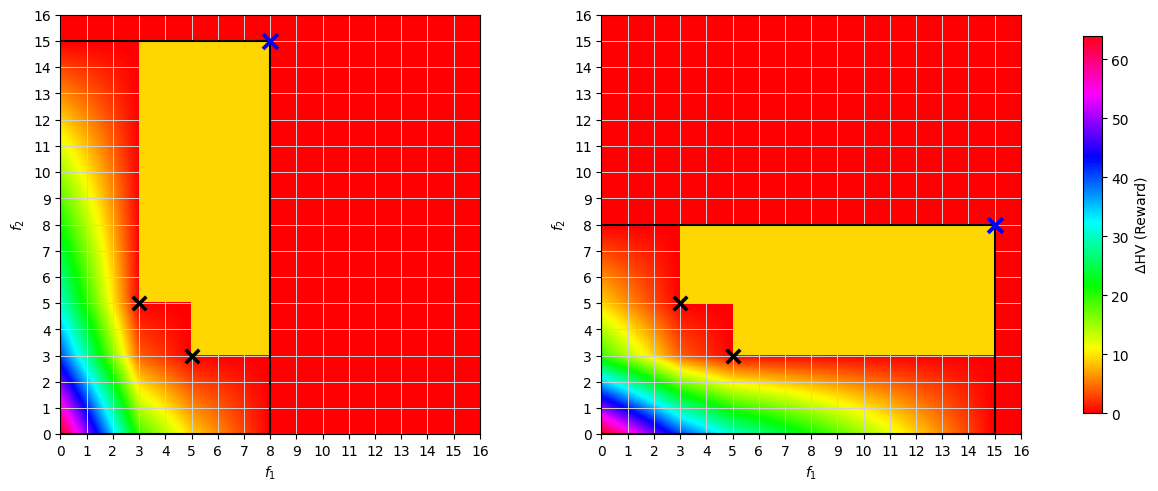

In [55]:
# ΔHV-Heatmaps (Grau), HV-Union Gelb, R=Blau (x), S=Schwarz (x)
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import to_rgba, Normalize

# --- Globale Styles: Hintergrund weiß, Schrift schwarz ---
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
    "text.color": "black",
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "axes.edgecolor": "black",
})

# ---------- Geometrie / HV ----------
def rect_from_point(p, R):
    x, y = p
    rx, ry = R
    w, h = rx - x, ry - y
    if w <= 0 or h <= 0:
        return None
    return (x, y, w, h)

def union_area(rects):
    xs = set()
    clean = []
    for r in rects:
        if r is None:
            continue
        x, y, w, h = r
        if w <= 0 or h <= 0:
            continue
        clean.append((x, x+w, y, y+h))
        xs.add(x); xs.add(x+w)
    if not clean:
        return 0.0
    xs = sorted(xs)
    total = 0.0
    for i in range(len(xs)-1):
        xa, xb = xs[i], xs[i+1]
        if xb <= xa:
            continue
        intervals = []
        for x1, x2, y1, y2 in clean:
            if x1 < xb and x2 > xa:
                intervals.append((y1, y2))
        if not intervals:
            continue
        intervals.sort()
        merged = []
        cy1, cy2 = intervals[0]
        for y1, y2 in intervals[1:]:
            if y1 <= cy2:
                cy2 = max(cy2, y2)
            else:
                merged.append((cy1, cy2))
                cy1, cy2 = y1, y2
        merged.append((cy1, cy2))
        ylen = sum(b - a for a, b in merged)
        total += (xb - xa) * ylen
    return total

def delta_hv(S_points, cand, R):
    rects_S = [rect_from_point(s, R) for s in S_points]
    rc = rect_from_point(cand, R)
    return union_area(rects_S + [rc]) - union_area(rects_S)

def compute_heatmap(S_points, R, XMAX=16, YMAX=16, n=240):
    xs = np.linspace(0, XMAX, n)
    ys = np.linspace(0, YMAX, n)
    Z = np.zeros((n, n), dtype=float)
    for i, y in enumerate(ys):
        for j, x in enumerate(xs):
            z = delta_hv(S_points, (x, y), R)
            Z[i, j] = max(0.0, z)
    return xs, ys, Z

# ---------- Visuals ----------
def draw_hv_union_overlay(ax, S, R, color="#FFD700", res=500, zorder=3):
    """HV-Union als deckende gelbe Fläche (keine Transparenz im HV-Bereich)."""
    rx, ry = R
    xs = np.linspace(0, rx, res)
    ys = np.linspace(0, ry, res)
    X, Y = np.meshgrid(xs, ys)

    mask = np.zeros_like(X, dtype=bool)
    for sx, sy in S:
        mask |= (X >= sx) & (Y >= sy)

    overlay = np.zeros((res, res, 4), dtype=float)
    overlay[mask] = to_rgba(color, 1.0)  # voll deckend Gelb

    ax.imshow(
        overlay, origin="lower",
        extent=[0, rx, 0, ry],
        interpolation="nearest",
        zorder=zorder
    )

def style_axes_black(ax):
    for spine in ax.spines.values():
        spine.set_color("black")
    ax.tick_params(colors="black", which="both")

def draw_panel(ax, S, xs, ys, Z, R, norm):
    # Heatmap in Graustufen (weiß=klein, schwarz=groß)
    im = ax.imshow(
        Z, origin="lower",
        extent=[xs[0], xs[-1], ys[0], ys[-1]],
        aspect="equal", cmap="hsv", norm=norm, zorder=1
    )

    # HV-Union deckend Gelb
    draw_hv_union_overlay(ax, S, R, color="#FFD700", res=500, zorder=2)

    # Kandidaten-Box [0,Rx]×[0,Ry] obenauf
    ax.add_patch(Rectangle((0,0), R[0], R[1], fill=False, linewidth=1.5, edgecolor="black", zorder=4))

    # Punkte: S schwarz (x), R blau (x)
    ax.scatter([S[0][0]],[S[0][1]], s=95, marker="x", c="black", linewidths=2.6, zorder=5)
    ax.scatter([S[1][0]],[S[1][1]], s=95, marker="x", c="black", linewidths=2.6, zorder=5)
    ax.scatter([R[0]],[R[1]],       s=115, marker="x", c="blue",  linewidths=2.8, zorder=6)

    # Achsen & Grid (Text schwarz, Hintergrund weiß)
    ax.set_xlabel("$f_1$")
    ax.set_ylabel("$f_2$")
    ax.xaxis.set_major_locator(MultipleLocator(1.0))
    ax.yaxis.set_major_locator(MultipleLocator(1.0))
    ax.grid(True, which="major", linewidth=0.7, color="#D0D0D0")
    style_axes_black(ax)
    return im

def show_heatmaps_grid(
    S, R_list, XMAX=16, YMAX=16, n=240,
    ncols=2, figsize=(12.0, 4.8)
):
    # Heatmaps vorbereiten
    data = []
    for R in R_list:
        xs, ys, Z = compute_heatmap(S, R, XMAX=XMAX, YMAX=YMAX, n=n)
        data.append((R, xs, ys, Z))

    # Gemeinsame lineare Skala
    Z_all = np.concatenate([Z.ravel() for (_,_,_,Z) in data])
    Z_all = Z_all[np.isfinite(Z_all)]
    if Z_all.size == 0:
        Z_all = np.array([0.0, 1.0])
    norm = Normalize(vmin=0.0, vmax=float(np.max(Z_all)))

    # Raster
    nplots = len(R_list)
    nrows = math.ceil(nplots / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False, constrained_layout=True)
    fig.patch.set_facecolor("white")
    axes = axes.ravel()

    ims = []
    for i, (R, xs, ys, Z) in enumerate(data):
        im = draw_panel(axes[i], S, xs, ys, Z, R, norm)
        ims.append(im)

    # Unbenutzte Achsen ausblenden
    for j in range(i+1, nrows*ncols):
        axes[j].axis("off")

    # Gemeinsame Farbleiste (Text schwarz)
    cbar = fig.colorbar(ims[0], ax=axes[:nplots], shrink=0.9, label="ΔHV (Reward)")
    cbar.ax.tick_params(colors="black")
    cbar.set_label("ΔHV (Reward)", color="black")
    plt.savefig("delta_hv_heatmaps.png", dpi=600, bbox_inches="tight",
            facecolor="white", edgecolor="white")
    plt.show()

# ---------- Beispiel ----------
S = [(3.0, 5.0), (5.0, 3.0)]
R_list = [(8.0, 15.0), (15.0, 8.0)]  # oder [(6.0,12.0), (12.0,6.0)]

show_heatmaps_grid(
    S, R_list,
    ncols=2, figsize=(12.0, 4.8)
)


<Figure size 640x480 with 0 Axes>

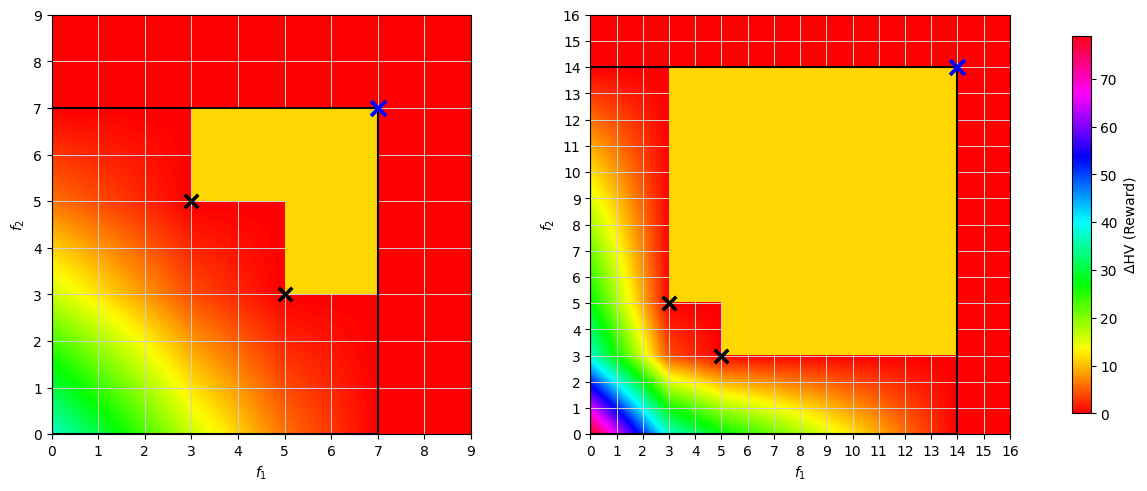

In [61]:
# --- TRUNCATION FIGURE: zeigt, dass HV(s,S,r)=0 gilt, wenn s_k >= r_k für mind. ein k ---
import os, math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

def autoscale_limits(S, R, pad=1.0):
    xs = [p[0] for p in S] + [R[0]]
    ys = [p[1] for p in S] + [R[1]]
    XMAX = math.ceil(max(xs) + pad)
    YMAX = math.ceil(max(ys) + pad)
    return XMAX, YMAX

def show_truncation_heatmaps(
    S, R_small, R_large, n=240, figsize=(12.0, 4.8), outpath="gfx/hvc_truncation_heatmaps.png"
):
    # Heatmaps berechnen
    XMAX_s, YMAX_s = autoscale_limits(S, R_small, pad=2.0)
    xs_s, ys_s, Z_s = compute_heatmap(S, R_small, XMAX=XMAX_s, YMAX=YMAX_s, n=n)

    XMAX_l, YMAX_l = autoscale_limits(S, R_large, pad=2.0)
    xs_l, ys_l, Z_l = compute_heatmap(S, R_large, XMAX=XMAX_l, YMAX=YMAX_l, n=n)

    # Gemeinsame Norm, damit Farbwerte vergleichbar sind
    Z_all = np.concatenate([Z_s.ravel(), Z_l.ravel()])
    Z_all = Z_all[np.isfinite(Z_all)]
    vmax = float(np.max(Z_all)) if Z_all.size else 1.0
    norm = Normalize(vmin=0.0, vmax=vmax)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=figsize, constrained_layout=True)
    draw_panel(axes[0], S, xs_s, ys_s, Z_s, R_small, norm)

    draw_panel(axes[1], S, xs_l, ys_l, Z_l, R_large, norm)

    cbar = fig.colorbar(axes[0].images[0], ax=axes, shrink=0.9, label="ΔHV (Reward)")
    cbar.ax.tick_params(colors="black")
    cbar.set_label("ΔHV (Reward)", color="black")

    os.makedirs(os.path.dirname(outpath), exist_ok=True)
    plt.savefig(outpath, dpi=600, bbox_inches="tight", facecolor="white", edgecolor="white")
    plt.show()

# --- Beispielaufruf (gleiches S wie in deiner Abbildung) ---
S = [(3.0, 5.0), (5.0, 3.0)]
R_small = (7.0, 7.0)
R_large = (14.0, 14.0)
show_truncation_heatmaps(S, R_small, R_large, n=240, figsize=(12.0, 4.8))


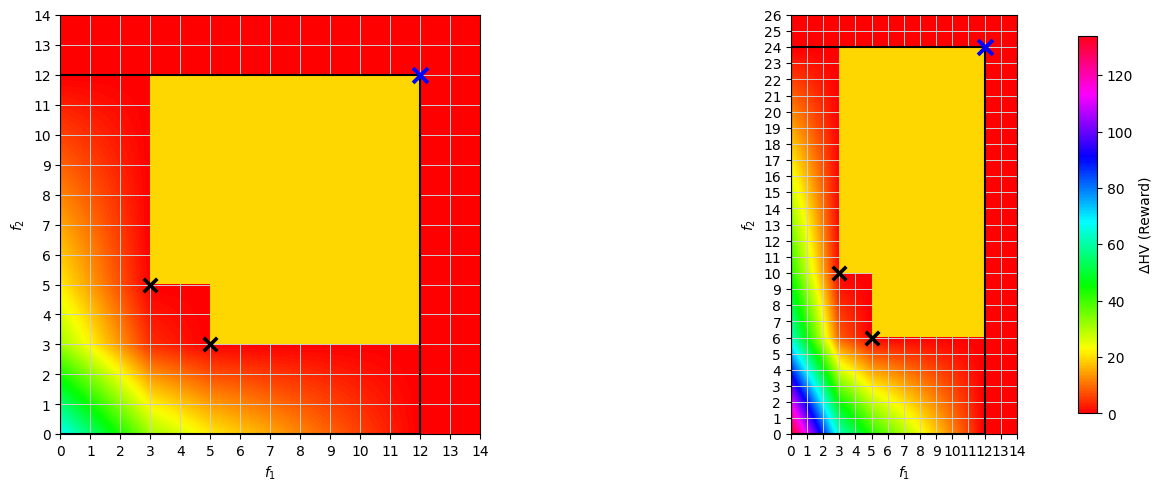

In [62]:
# --- SCALE BIAS FIGURE: skaliert eine Zielgröße linear und zeigt die veränderte Belohnungslandschaft ---
import os, math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

def scale_objectives(S, R, scale=(1.0, 2.0)):
    """Skaliert die Ziele komponentenweise: (x, y) -> (scale[0]*x, scale[1]*y)."""
    a, b = scale
    S_scaled = [(a*sx, b*sy) for (sx, sy) in S]
    R_scaled = (a*R[0], b*R[1])
    return S_scaled, R_scaled

def show_scale_bias_heatmaps(
    S_base, R_base, scale=(1.0, 2.0), n=240, figsize=(12.0, 4.8), outpath="gfx/hvc_scale_heatmaps.png"
):
    # Basisskala
    def autoscale_limits(S, R, pad=2.0):
        xs = [p[0] for p in S] + [R[0]]
        ys = [p[1] for p in S] + [R[1]]
        return math.ceil(max(xs) + pad), math.ceil(max(ys) + pad)

    XMAX_b, YMAX_b = autoscale_limits(S_base, R_base)
    xs_b, ys_b, Z_b = compute_heatmap(S_base, R_base, XMAX=XMAX_b, YMAX=YMAX_b, n=n)

    # Skalierte Ziele (inkl. skaliertem Referenzpunkt)
    S_sc, R_sc = scale_objectives(S_base, R_base, scale=scale)
    XMAX_s, YMAX_s = autoscale_limits(S_sc, R_sc)
    xs_s, ys_s, Z_s = compute_heatmap(S_sc, R_sc, XMAX=XMAX_s, YMAX=YMAX_s, n=n)

    # Gemeinsame Norm für Vergleichbarkeit
    Z_all = np.concatenate([Z_b.ravel(), Z_s.ravel()])
    Z_all = Z_all[np.isfinite(Z_all)]
    vmax = float(np.max(Z_all)) if Z_all.size else 1.0
    norm = Normalize(vmin=0.0, vmax=vmax)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=figsize, constrained_layout=True)
    draw_panel(axes[0], S_base, xs_b, ys_b, Z_b, R_base, norm)

    draw_panel(axes[1], S_sc, xs_s, ys_s, Z_s, R_sc, norm)

    cbar = fig.colorbar(axes[0].images[0], ax=axes, shrink=0.9, label="ΔHV (Reward)")
    cbar.ax.tick_params(colors="black")
    cbar.set_label("ΔHV (Reward)", color="black")

    os.makedirs(os.path.dirname(outpath), exist_ok=True)
    plt.savefig(outpath, dpi=600, bbox_inches="tight", facecolor="white", edgecolor="white")
    plt.show()

# --- Beispielaufruf ---
S_base = [(3.0, 5.0), (5.0, 3.0)]
R_base = (12.0, 12.0)
show_scale_bias_heatmaps(S_base, R_base, scale=(1.0, 2.0), n=240, figsize=(12.0, 4.8))
